In [1]:
%pylab inline
%run common.py
import tradingWithPython as twp

Populating the interactive namespace from numpy and matplotlib


# Working with csv files

## Reading csv

[ref]: # (csv files - reading)
[ref]: # (data io - csv files)

[Csv files](http://en.wikipedia.org/wiki/Comma-separated_values) are frequently used for price data storage. This a very  popular method because:

* Files are plain text, human readable
* Supported by most systems

Let's take a look at working with this type of data. 

To start we need an example csv file. The code below creates a `tmp` subdirectory and writes `test.csv` into it. 

By the way, we use a *multiline* string notation below. By using triple quotes, the newline characters are included in the string.

In [2]:
import os
if not os.path.exists('tmp'): 
    os.mkdir('tmp') # create tmp subdirectory if it does not exist yet

#------write data to test.csv     
txt = """date, colB, colC
01-01-2013,2,a
02-01-2013,4,b
03-01-2013,6,c
"""

with open('tmp/test.csv','w') as f: # with ... open ... as  is a robust way to open a file and read/write to it
    f.write(txt)
    
    

### The easy way

[ref]: # (csv files - reading with pandas)

The easiest way to load a csv file is to use [`DataFrame.from_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_csv.html) or [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) functions from pandas. When it parses data correctly, it is the best way to read and write csv files. However, there are some situations where the result is not exactly what you would expect. 
Let's read our `test.csv`  , the *date* column should be used as index and converted to `datetime` type.

In [3]:
import pandas as pd
df = pd.read_csv('tmp/test.csv') # load DataFrame from csv
print('Data types:\n--------------\n', df.dtypes) # show column types
df # output dataframe in pretty formatting

Data types:
--------------
 date     object
 colB     int64
 colC    object
dtype: object


,date,colB,colC
0,01-01-2013,2,a
1,02-01-2013,4,b
2,03-01-2013,6,c


In this case the columns are read correctly, but the date, which we actually want to be the index column is not parsed (it is still a string). An index has also been automatically added. This can be fixed by specifying some parameters (see the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) for all options):

In [4]:
df = pd.read_csv('tmp/test.csv',index_col=0, header=0,dayfirst=True,parse_dates=True) # load DataFrame from csv
print('Data types:\n--------------\n', df.dtypes) # show column types
df

Data types:
--------------
  colB     int64
 colC    object
dtype: object


,colB,colC
date,,
2013-01-01,2,a
2013-01-02,4,b
2013-01-03,6,c


In [5]:
df.index[0]

Timestamp('2013-01-01 00:00:00')

This looks better! 
For the (rare) cases where `read_csv()` does not work as you would like there is always a manual way of parsing file line-by-line. 
The code below is provided mainly for illustrative purposes, showing how to manually parse a text file.

### The hard way

[ref]: # (csv files - parse manually)

The advantage of doing this manually is that you can parse any type of csv file exactly to your liking.This is the method I use for parsing most of the csv data coming from the net (see `yahooFinance.py` in the TWP library).
The code below parses a csv in several steps:

1. read text lines from file
2. parse header data
3. fill `data` array with values, converting strings to the right data type
4. create a dictionary of header-data pairs
5. create a DataFrame


First a simple example of parsing a single line:

In [6]:
# example of parsing a single line
s = 'foo,bar,24'  # create a string consisting of two substrings and a number
l = s.split(',') # split string to a list, using ',' as a separator
int(l[2]) # convert third element to an integer

24

...and now parsing the csv file we saved earlier

In [7]:
import datetime as dt # shorthand notation for datetime module

#---------- read lines from file
with open('tmp/test.csv','r') as f: # open file
    lines = f.readlines() # read all lines to a list
    
print('lines:',lines)

#----------- parse header
header = lines[0].strip().split(',') # strip whitespace, split on ','. 
print('header:', header)

#------------parse data
data = [[],[],[]] # create an empty array for each column data

for line in lines[1:]:  # start at second line, because first line is header
    values = line.strip().split(',') # get the values from a line 
    data[0].append(dt.datetime.strptime(values[0],"%d-%m-%Y").date()) # parse date and append to column 0
    data[1].append(int(values[1])) # conert to int and append to column 1
    data[2].append(values[2]) # append to column 2, no conversion needed
    
print('data:', data)

#----------create a dictionary with column-data . Column 0 is discarded as it is an index and not data
dataDict = dict(list(zip(header[1:],data[1:])))
print('dataDict:',dataDict)

#-----------finally create the dataframe
df =pd.DataFrame(data=dataDict, index=data[0]) # use standard constructor to create a dataframe

df


lines: ['date, colB, colC\n', '01-01-2013,2,a\n', '02-01-2013,4,b\n', '03-01-2013,6,c\n']
header: ['date', ' colB', ' colC']
data: [[datetime.date(2013, 1, 1), datetime.date(2013, 1, 2), datetime.date(2013, 1, 3)], [2, 4, 6], ['a', 'b', 'c']]
dataDict: {' colB': [2, 4, 6], ' colC': ['a', 'b', 'c']}


,colB,colC
2013-01-01,2,a
2013-01-02,4,b
2013-01-03,6,c




### Advanced example
We'll use a Put/Call datafrom CBOE as an example. This file can be parsed automatically, but we'll be doing it manually first to learn how to do it.

The following piece of code downloads the data using `urllib2` module to a `lines` list. Each element of the list now contains a single line from the online url. Saving to disk is not neccesary. To take a look at the file, just click [this link](http://www.cboe.com/publish/ScheduledTask/MktData/datahouse/totalpc.csv) to download it through your browser.
Steps taken to parse this file are similar to the steps taken in the simple example above, but while previous code was written for easy reading, the following code uses a couple of tricks to automate iterating through the coulumns.

[ref]: # (getting data - get put/call data from CBOE)

In [8]:
import urllib.request, urllib.error, urllib.parse

urlStr = 'http://www.cboe.com/publish/ScheduledTask/MktData/datahouse/totalpc.csv'
lines = urllib.request.urlopen(urlStr).readlines() # get all data to lines list


Now let's print several lines

In [9]:
for lineNr, line in enumerate(lines[:10]):
    print('[lineNr %i]%s ' % (lineNr,line))

[lineNr 0]b'Volume and Put/Call Ratio data is compiled for the convenience of site visitors and is furnished without responsibility for accuracy and is accepted by the site visitor on the condition that transmission or omissions shall not be made the basis for any claim demand or cause for action.  Historical index volume from November 1 2006 through May 31 2012 is based on cleared volume as reported by the OCC. The volume data reflected after May 31 2012 below is based upon preliminary reported volume rather than cleared volume. The information and data was obtained from sources believed to be reliable but accuracy is not guaranteed. Your use of Cboe Volume and Put/Call Ratio data is subject to the Terms and Conditions of Cboe Websites.,,,,\r\n' 
[lineNr 1]b', PRODUCT: TOTAL,,EXCHANGE: Cboe,\r\n' 
[lineNr 2]b'DATE,CALLS,PUTS,TOTAL,P/C Ratio\r\n' 
[lineNr 3]b'11/1/2006,1401036,1271445,2672481,0.91\r\n' 
[lineNr 4]b'11/2/2006,1348240,1218592,2566832,0.9\r\n' 
[lineNr 5]b'11/3/2006,13173

Line 2 contains column names, which now goes to the `header` list

In [10]:
headerLine = 2 # line number
header = lines[headerLine].decode().strip().split(',') # strip whitespace from line, and split it on ','

print(header)

['DATE', 'CALLS', 'PUTS', 'TOTAL', 'P/C Ratio']


Now create a list that will hold the actual data. It is a list of lists, one for each column

In [11]:
columnData =   [[] for i in range(len(header))] # create empty list for each data column

print(columnData)

[[], [], [], [], []]


Now the data can be filled by iterating through each line after the header. 

In [12]:
import datetime as dt # shorthand notation for datetime module
import pandas as pd

for line in lines[(headerLine+1):]: # for each line starting after header line
        fields = line.decode().rstrip().split(',') # split line to data fields. Each field is a string
        # first field is the date, it is treated separately because it must be converted to
        #datetime format. String from first field is appended to data[0]
        columnData[0].append(dt.datetime.strptime(fields[0],'%m/%d/%Y').date()) 
        
        # the rest of the fields are converted to floats in a loop
        for i,field  in enumerate(fields[1:]): # for all fields from 1. i is the field number-1
            columnData[i+1].append(float(field)) # convert data to float and append it to a column data

d =   dict(list(zip(header[1:],columnData[1:]))) # create a dictionary with header-columnData pairs, exclude column 0       
            
df = pd.DataFrame(d, index = pd.Index(columnData[0])) #create DataFrame with index from column 0

df.tail(10)

,CALLS,P/C Ratio,PUTS,TOTAL
2018-02-06,5.74e+06,0.99,5.67e+06,1.14e+07
2018-02-07,4.06e+06,0.91,3.67e+06,7.73e+06
2018-02-08,3.92e+06,1.14,4.45e+06,8.37e+06
2018-02-09,3.99e+06,1.31,5.24e+06,9.23e+06
2018-02-12,3.57e+06,0.94,3.37e+06,6.94e+06
2018-02-13,3.04e+06,0.96,2.90e+06,5.94e+06
2018-02-14,2.98e+06,1.17,3.48e+06,6.46e+06
2018-02-15,3.18e+06,0.92,2.93e+06,6.11e+06
2018-02-16,3.31e+06,0.93,3.07e+06,6.38e+06
2018-02-20,2.40e+06,0.86,2.06e+06,4.45e+06


### And the very easy way again
`read_csv` can accept a `buffer` as input and parse it automatically. So getting the data from the net and parsing it can be done on one single line!

In [13]:
df = pd.read_csv(urllib.request.urlopen(urlStr), header = 2, index_col=0,parse_dates=True)
df

,CALLS,PUTS,TOTAL,P/C Ratio
DATE,,,,
2006-11-01,1401036,1271445,2672481,0.91
2006-11-02,1348240,1218592,2566832,0.90
2006-11-03,1317371,1197794,2515165,0.91
2006-11-06,1260832,960752,2221584,0.76
2006-11-07,1463685,1158790,2622475,0.79
...,...,...,...,...
2018-02-13,3039673,2903417,5943090,0.96
2018-02-14,2981929,3481044,6462973,1.17
2018-02-15,3179289,2929984,6109273,0.92


,CALLS,PUTS,TOTAL,P/C Ratio
DATE,,,,
2018-02-13,3039673,2903417,5943090,0.96
2018-02-14,2981929,3481044,6462973,1.17
2018-02-15,3179289,2929984,6109273,0.92
2018-02-16,3307999,3067685,6375684,0.93
2018-02-20,2396334,2055649,4451983,0.86


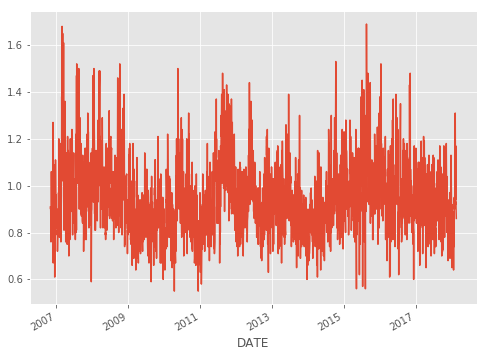

In [14]:
df['P/C Ratio'].plot()
df.tail()

## Writing csv files

[ref]: # (csv files - writing)

Normally you would not need to write csv files manually.  `DataFrame.to_csv()` takes care of this:

In [15]:
df.to_csv('tmp/pc_ratio.csv')
df

,CALLS,PUTS,TOTAL,P/C Ratio
DATE,,,,
2006-11-01,1401036,1271445,2672481,0.91
2006-11-02,1348240,1218592,2566832,0.90
2006-11-03,1317371,1197794,2515165,0.91
2006-11-06,1260832,960752,2221584,0.76
2006-11-07,1463685,1158790,2622475,0.79
...,...,...,...,...
2018-02-13,3039673,2903417,5943090,0.96
2018-02-14,2981929,3481044,6462973,1.17
2018-02-15,3179289,2929984,6109273,0.92


A big advantage is that the files written by `DataFrame.to_csv()`, will also be readable by `DataFrame.read_csv()` and `read_csv()` functions

<div class="alert alert-info">
**note:**

  `DataFrame.read_csv()` will be depreciated in the future. It is better to use `read_csv()`.
</div>

In [16]:
df2 = pd.read_csv('tmp/pc_ratio.csv', index_col=0,parse_dates=True)
df2.tail()

,CALLS,PUTS,TOTAL,P/C Ratio
DATE,,,,
2018-02-13,3039673,2903417,5943090,0.96
2018-02-14,2981929,3481044,6462973,1.17
2018-02-15,3179289,2929984,6109273,0.92
2018-02-16,3307999,3067685,6375684,0.93
2018-02-20,2396334,2055649,4451983,0.86


In [17]:
df2.index

DatetimeIndex(['2006-11-01', '2006-11-02', '2006-11-03', '2006-11-06',
               '2006-11-07', '2006-11-08', '2006-11-09', '2006-11-10',
               '2006-11-13', '2006-11-14',
               ...
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
               '2018-02-16', '2018-02-20'],
              dtype='datetime64[ns]', name='DATE', length=2844, freq=None)

In [18]:
df3 = pd.DataFrame.from_csv('tmp/pc_ratio.csv') # this works, but produces a depreciation warning. Not recommended.
df3

/home/jev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,CALLS,PUTS,TOTAL,P/C Ratio
DATE,,,,
2006-11-01,1401036,1271445,2672481,0.91
2006-11-02,1348240,1218592,2566832,0.90
2006-11-03,1317371,1197794,2515165,0.91
2006-11-06,1260832,960752,2221584,0.76
2006-11-07,1463685,1158790,2622475,0.79
...,...,...,...,...
2018-02-13,3039673,2903417,5943090,0.96
2018-02-14,2981929,3481044,6462973,1.17
2018-02-15,3179289,2929984,6109273,0.92
